In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from typing import List

# The Black-Scholes hedging strategy

In [2]:
# Constants
N = 1000
T = 1.5
S0 = 100
sigma = 0.3
r = 0.05

n = 100

mus = [0.05, 0.02, 0.45]
Ks = np.arange(80,121)
ns = [100, 500, 1000, 2000]

## Exercise 1

In [3]:
def generate_brownian_motion(n: int) -> np.array:
    dt = T/n
    
    # Generate increments of Brownian motion
    w = np.random.normal(0, np.sqrt(dt), (N,n))
    w = w.cumsum(axis = 1)
    
    # Adding start at 0
    w = np.concatenate([np.zeros((N,1)), w], axis = 1)

    return w

def generate_discrete_path(n: int, mu: float) -> np.array:
    w = generate_brownian_motion(n)
    t = (np.arange(n+1)/n * T)
    
    return S0 * np.exp((mu - sigma**2 / 2)*t + sigma*w)

In [4]:
for mu in mus:
    S = generate_discrete_path(n, mu)
    
    print(f"Results for mu = {mu}:")
    print(f"Mean value of S at end point: {S[:,-1].mean()}")
    print(f"Variance of S at end point: {S[:,-1].var()}")
    print(f"Standard deviation of S at end point: {S[:,-1].std()}")
    print()

Results for mu = 0.05:
Mean value of S at end point: 106.50553150948221
Variance of S at end point: 1574.5995078989822
Standard deviation of S at end point: 39.681223618973526

Results for mu = 0.02:
Mean value of S at end point: 103.80181103325222
Variance of S at end point: 1514.3895885000575
Standard deviation of S at end point: 38.91515885230404

Results for mu = 0.45:
Mean value of S at end point: 198.4952967219631
Variance of S at end point: 5232.156180259846
Standard deviation of S at end point: 72.33364487055692



Results are rather intuitive. Higher drift will lead to higher values of $S_{T}$. It is also interesting to observe that it will also lead to higher variance. This can be fairly easily checked theoretically:

$$
\mathbb{E}[S_{T}] = S_{0}e^{(\mu - \frac{\sigma^{2}}{2})T}\mathbb{E}[e^{\sigma W_{T}}]
$$

$$
\mathbb{V}[S_{T}] = S_{0}e^{(2\mu - \sigma^{2})T}\mathbb{V}[e^{\sigma W_{T}}]
$$

Which agrees with our observations.

## Exercise 2

### Main functions for this exercise

In [5]:
def d_plus(s: float, k: float, v: float) -> float:
    return np.log(s/k)/np.sqrt(v) + 0.5 * np.sqrt(v)

def d_minus(s: float, k: float, v: float) -> float:
    return np.log(s/k)/np.sqrt(v) - 0.5 * np.sqrt(v)

def BS(K: float):
    '''
    No Arbitrage price of a European call
    '''
    dp = d_plus(S0, K*np.exp(-r*T), T*sigma**2)
    dm = d_minus(S0, K*np.exp(-r*T), T*sigma**2)
    
    return S0 * scipy.stats.norm.cdf(dp) - K * np.exp(-r*T) * scipy.stats.norm.cdf(dm)

def delta(K: float, S: np.array):
    '''
    Computes hedging
    '''
    n = S.shape[1] - 1
    ts = (np.arange(n+1)/n) * T

    return scipy.stats.norm.cdf(d_plus(S, K*np.exp(-r*(T-ts)), (T-ts)*sigma**2))

def compute_X(K: float, S: np.array) -> np.array:
    n = S.shape[1] - 1
    ts = (np.arange(n+1)/n) * T
    
    D = delta(K, S)
    
    sum_term = (D[:,:-1] * (np.exp(-r*ts[1:])*S[:,1:] - np.exp(-r*ts[:-1])*S[:,:-1])).sum(axis = 1)
    
    return (BS(K) + sum_term) * np.exp(r*T)
    
def compute_pnl(K: float, S: np.array) -> np.array:
    ST = S[:,-1]
    X = compute_X(K, S)
    
    return X - np.maximum(ST - K, 0)

### Exercise 2.a

/tmp/ipykernel_10444/2275712517.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.log(s/k)/np.sqrt(v) + 0.5 * np.sqrt(v)


mu = 0.05
Mean of X: 17.719346623029267
Standard deviation of x: 29.68023972672507


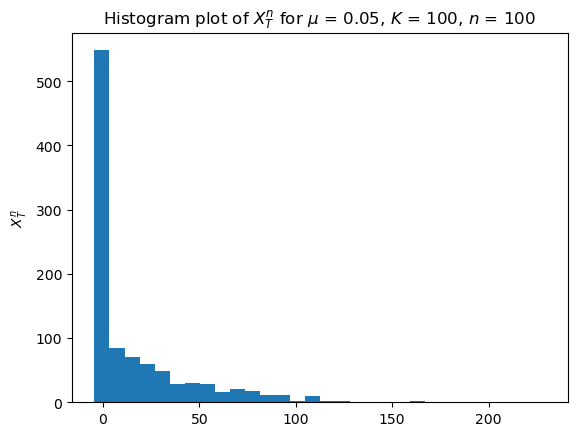

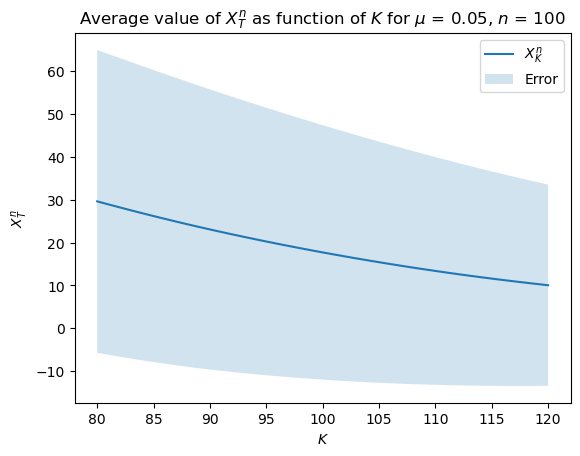

mu = 0.02
Mean of X: 15.584817749174983
Standard deviation of x: 26.773616939939927


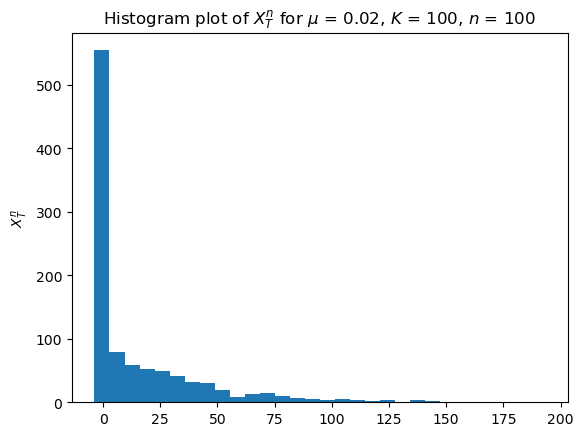

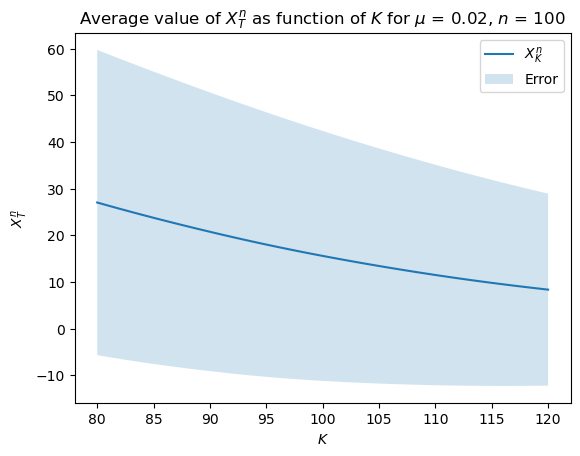

mu = 0.45
Mean of X: 97.11131867943384
Standard deviation of x: 73.98068794257911


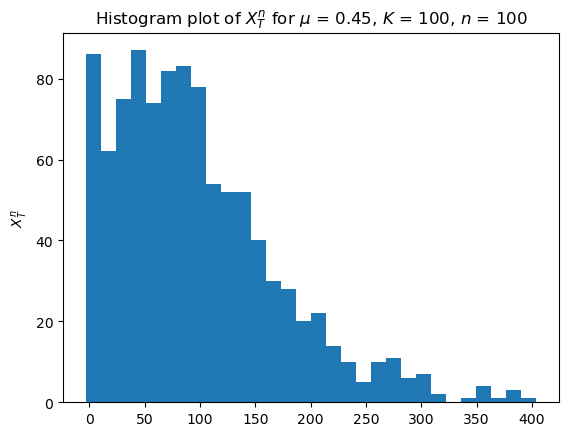

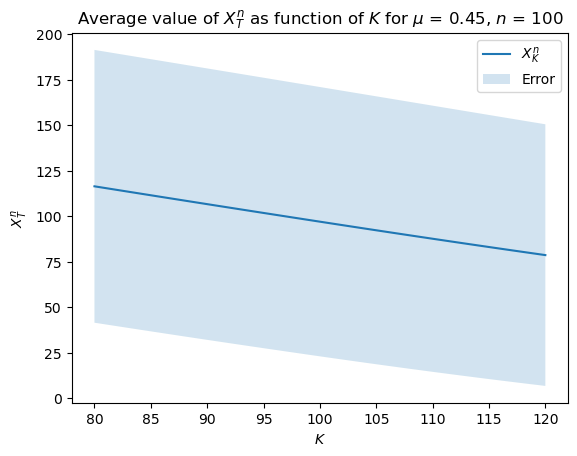

In [6]:
for mu in mus:
    K = S0
    S = generate_discrete_path(n, mu)
    X = compute_X(100, S)
    
    print(f"mu = {mu}")
    print(f"Mean of X: {X.mean()}")
    print(f"Standard deviation of x: {X.std()}")
    
    plt.title(f'Histogram plot of $X_T^n$ for $\mu$ = {mu}, $K$ = {K}, $n$ = {n}')
    plt.hist(X, bins = 30)
    plt.ylabel('$X_{T}^{n}$')
    plt.show()
    
    Xks = np.zeros(len(Ks))
    err = np.zeros(len(Ks))
    for i, k in enumerate(Ks):
        Xk = compute_X(k, S)
        Xks[i] = Xk.mean()
        err[i] = Xk.std()
    
    plt.title(f'Average value of $X_T^n$ as function of $K$ for $\mu$ = {mu}, $n$ = {n}')
    plt.plot(Ks, Xks, label = '$X_K^n$')
    plt.fill_between(Ks, Xks - err, Xks + err, alpha = 0.2, label = 'Error')
    plt.xlabel('$K$')
    plt.ylabel('$X_{T}^{n}$')
    plt.legend()
    plt.show()
    

For the histogram plot we see similar distributions for $\mu = 0.05$ and $\mu = 0.02$. Basically most of our observations fall close to zero. When drift increases significantly, with $\mu = 0.45$ we see that $X^{n}_{T}$, shifts its distribution to higher values and is not anymore concentrated at zero.

As for the shape of the curve of the average value of $X^{n}_{T}$ as function of $K$ we see that for high drift it is semmly linear with respect to $K$.

### Exercise 2.b

Here we study each value of $\mu$ independently and make $K$ vary.

/tmp/ipykernel_10444/2275712517.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.log(s/k)/np.sqrt(v) + 0.5 * np.sqrt(v)


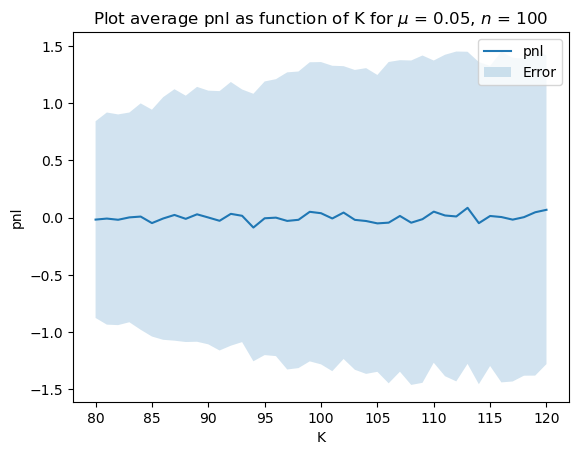

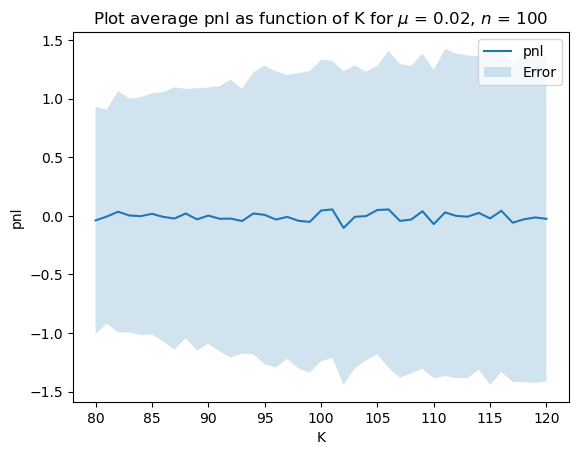

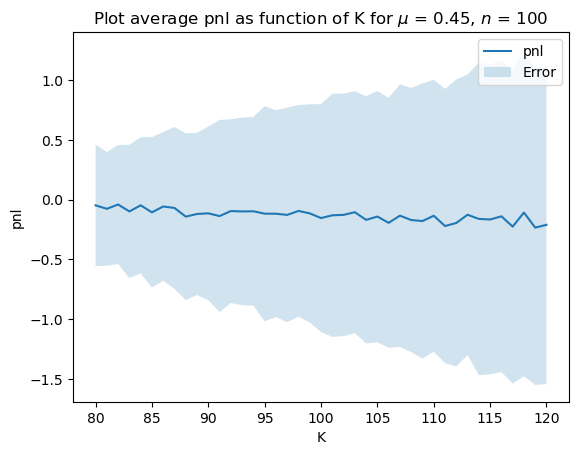

In [7]:
for mu in mus:
    pnls = np.zeros(len(Ks))
    err = np.zeros(len(Ks))

    for i, K in enumerate(Ks):
        S = generate_discrete_path(n, mu)
        pnl = compute_pnl(K, S)
        
        pnls[i] = pnl.mean()
        err[i] = pnl.std()
        
    plt.title(f'Plot average pnl as function of K for $\mu$ = {mu}, $n$ = {n}')
    plt.plot(Ks, pnls, label = 'pnl')
    plt.fill_between(Ks, pnls - err, pnls + err, alpha = 0.2, label = 'Error')
    plt.xlabel('K')
    plt.ylabel('pnl')
    plt.legend()
    plt.show()

We remark that all average pnls are centered at zero. This is rather expected as there is no arbitrage and we are dealing with a optimal hedging strategy. The portifolio is made so that there it's expected value is zero.

### Exercise 2.c

#### Analysis of mean

/tmp/ipykernel_10444/2275712517.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.log(s/k)/np.sqrt(v) + 0.5 * np.sqrt(v)


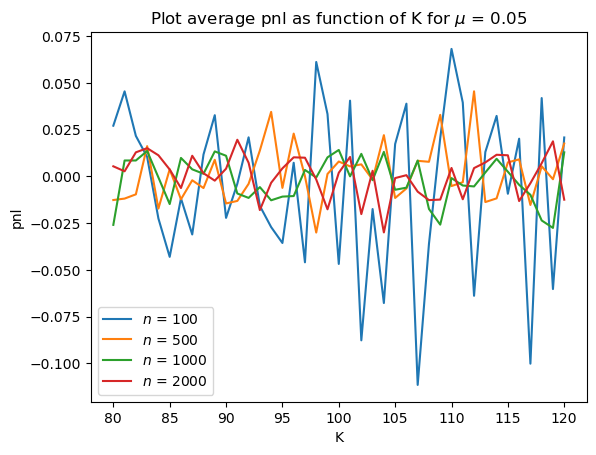

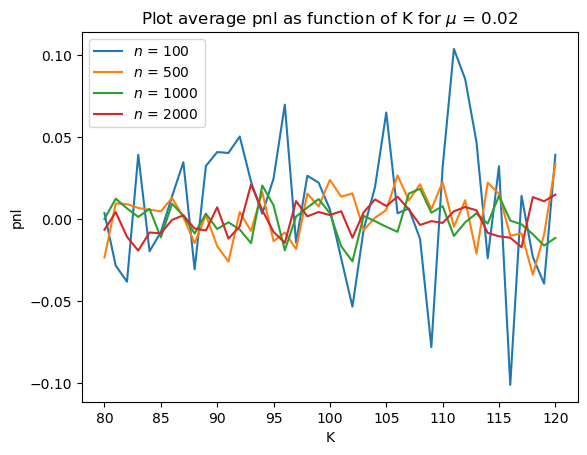

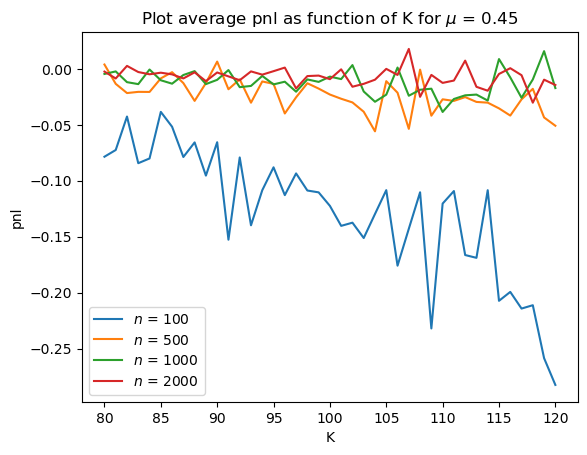

In [8]:
for mu in mus:
    for n in ns:
        pnls = np.zeros(len(Ks)) 

        for i, K in enumerate(Ks):
            S = generate_discrete_path(n, mu)
            pnl = compute_pnl(K, S)
            
            pnls[i] = pnl.mean()
            
        plt.plot(Ks, pnls, label = f'$n$ = {n}')
    
    plt.title(f'Plot average pnl as function of K for $\mu$ = {mu}')
    plt.xlabel('K')
    plt.ylabel('pnl')
    plt.legend()
    plt.show()

We remark that results do not vary significantly from the change in $n$, except when $n$ is very small for high drift.

We remark that as observed in question 2.b, the portifolio has expected value zero as we are performing the optimal hedging position. This may not happen when $n$ is small as positions are not update frequently enough to guarantee small deviations from the theoretical expected value of the pnl that is zero (no arbitrage).

#### Analysis of variance

/tmp/ipykernel_10444/2275712517.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.log(s/k)/np.sqrt(v) + 0.5 * np.sqrt(v)


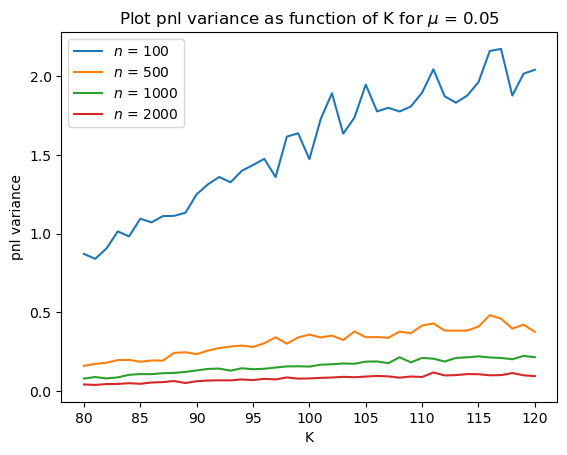

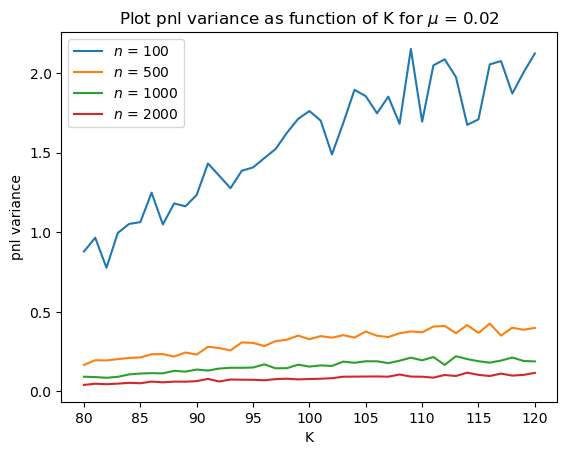

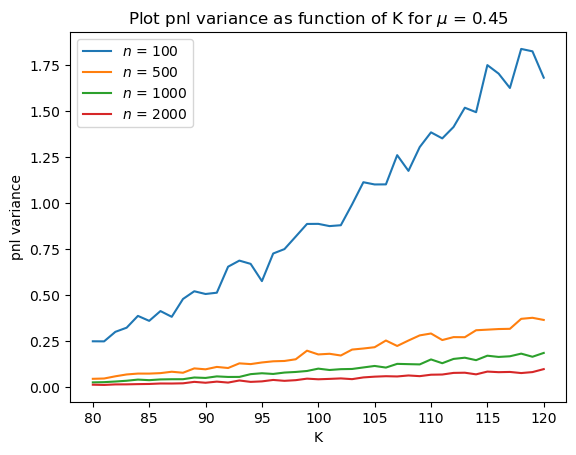

In [9]:
for mu in mus:
    for n in ns:
        pnls = np.zeros(len(Ks)) 

        for i, K in enumerate(Ks):
            S = generate_discrete_path(n, mu)
            pnl = compute_pnl(K, S)
            
            pnls[i] = pnl.var()
            
        plt.plot(Ks, pnls, label = f'$n$ = {n}')
    
    plt.title(f'Plot pnl variance as function of K for $\mu$ = {mu}')    
    plt.xlabel('K')
    plt.ylabel('pnl variance')
    plt.legend()
    plt.show()

We observe that the variance decrease as we increase the value of n. This result makes sense intuitively as higher values of $n$ mean that we update the position of our portifolio with a higher frequency, and thus better guarantee that we will meet the optimal hedge strategy from time $t_{n}$ to $t_{n+1}$. Hence we will have values that are closer to zero at $t=T$, thus reducing the variance of our sample.

Remark: The Runtime division by error happens because of the computation of $\Delta$ when $t = T$, but as we never take the value of $\Delta$ at this value of $t$, there is no influence in our calculations (see D[:,:-1]).